                                 Open        High         Low       Close  \
Date                                                                        
2015-03-16 00:00:00-04:00  174.252775  175.921876  173.536236  175.829147   
2015-03-17 00:00:00-04:00  175.078910  175.694283  174.480387  175.306519   
2015-03-18 00:00:00-04:00  174.826040  178.096815  174.176941  177.414001   
2015-03-19 00:00:00-04:00  176.992483  177.422399  176.208503  176.604706   
2015-03-20 00:00:00-04:00  177.570840  178.680074  177.384555  178.163559   
...                               ...         ...         ...         ...   
2023-12-21 00:00:00-05:00  466.926892  468.561502  464.460162  468.284119   
2023-12-22 00:00:00-05:00  469.433280  470.939100  467.293485  469.225250   
2023-12-26 00:00:00-05:00  469.641347  472.127878  469.562077  471.206573   
2023-12-27 00:00:00-05:00  470.998521  472.207125  470.453671  472.058533   
2023-12-28 00:00:00-05:00  472.425074  473.088798  471.810871  472.236847   

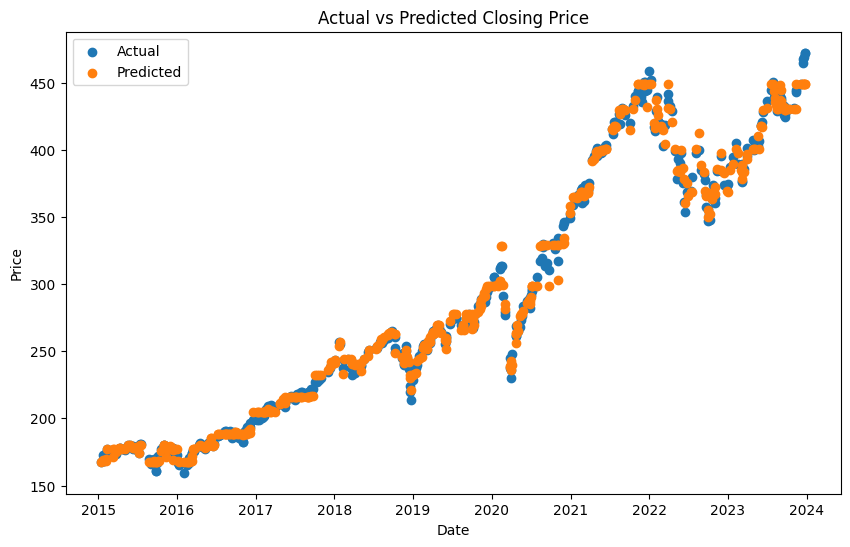

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import yfinance as yf

def calculate_rsi(data, period=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Download data
ticker = yf.Ticker('SPY')
start_date = '2015-01-01'
end_date = '2024-01-01'
data = ticker.history(start=start_date, end=end_date, period='1d')

# Create target first and drop NaN values
data['Target'] = data['Close'].shift(-1)
data.dropna(inplace=True)

# Clean data
try:
    data.drop(['Dividends', 'Stock Splits', 'Capital Gains'], inplace=True, axis=1)
except KeyError:
    print('Columns already dropped')

# Calculate features
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['RSI'] = calculate_rsi(data, period=14)

# Features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_50', 'SMA_50', 'RSI']
X = data[features]
y = data['Target']

data.dropna(inplace=True)
print(data)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model selection
model = RandomForestRegressor(n_estimators=500, max_depth=30,
                              min_samples_split=100, random_state=42)

# Train model
model.fit(X_train, y_train)

# Predict
Predicted = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, Predicted)
r2 = r2_score(y_test, Predicted)
print(f'MSE: {mse}')
print(f'R²: {r2}')

# Feature importance
feature_importances = model.feature_importances_
feature_names = features
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
print(feature_df.sort_values(by='Importance', ascending=False))

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, y_test.values, label='Actual')
plt.scatter(y_test.index, Predicted, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

